# Lab2 Master

In [5]:
import pandas as pd
import json
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 加載數據
data_identification = pd.read_csv("/content/data_identification.csv")
emotion = pd.read_csv("/content/emotion.csv")

# 加載 tweets 數據並轉換為 DataFrame
with open("/content/tweets_DM.json", "r") as file:
    tweets = [json.loads(line) for line in file]
tweets_df = pd.json_normalize([tweet['_source']['tweet'] for tweet in tweets])

# 合並
merged_data = data_identification.merge(tweets_df, on='tweet_id', how='left')
merged_data = merged_data.merge(emotion, on='tweet_id', how='left')

# 分離訓練和測試集
train_df = merged_data[merged_data['identification'] == 'train']
test_df = merged_data[merged_data['identification'] == 'test']


In [9]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# 定義預處理函數
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

# 應用預處理函數
train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-9-58056d4ba419>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['clean_text'] = train_df['text'].apply(preprocess_text)
<ipython-input-9-58056d4ba419>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['clean_text'] = test_df['text'].apply(preprocess_text)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])
y_train = train_df['emotion']


In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [12]:
y_pred = model.predict(X_test)


In [13]:
submission = test_df[['tweet_id']].copy()
submission['emotion'] = y_pred
submission.columns = ['id', 'emotion']
submission.to_csv("submission.csv", index=False)


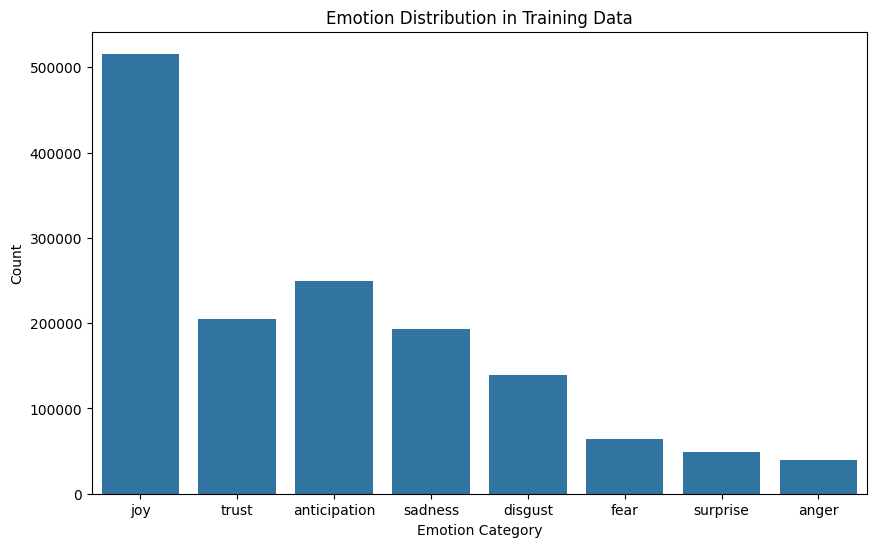

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 各情緒類別分佈
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=train_df)
plt.title("Emotion Distribution in Training Data")
plt.xlabel("Emotion Category")
plt.ylabel("Count")
plt.show()


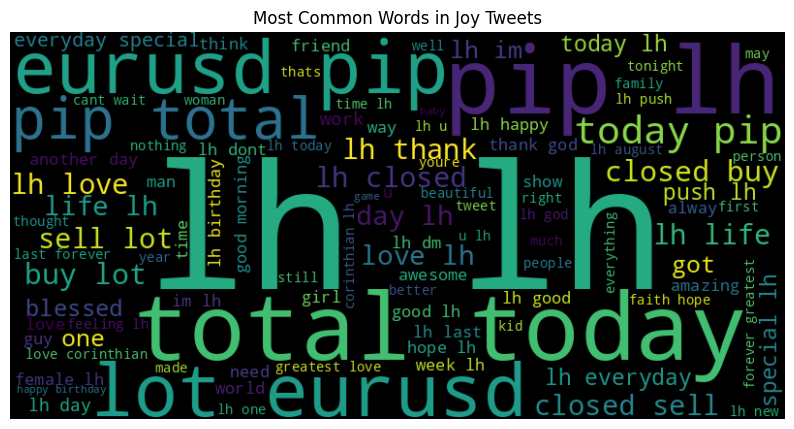

In [15]:
from wordcloud import WordCloud

# 創建詞雲圖（以 ''joy'' 類別爲例）
joy_text = ' '.join(train_df[train_df['emotion'] == 'joy']['clean_text'])
wordcloud = WordCloud(width=800, height=400, max_words=100).generate(joy_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Joy Tweets")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


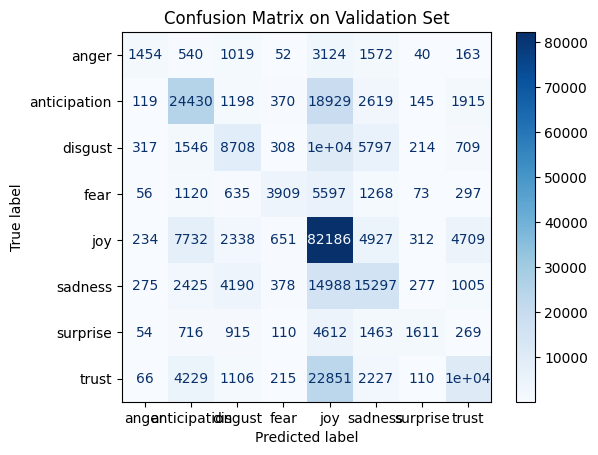

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 分割訓練集爲訓練子集和驗証集
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 使用訓練子集訓練模型
model.fit(X_train_part, y_train_part)

# 預測驗証集
y_val_pred = model.predict(X_val)

# 創建混淆矩陣
cm = confusion_matrix(y_val, y_val_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()
import numpy as np

# 檢查 NaN 值
if np.any(pd.isnull(y_val)) or np.any(pd.isnull(y_val_pred)):
    print("Error: There are NaN values in the target arrays.")


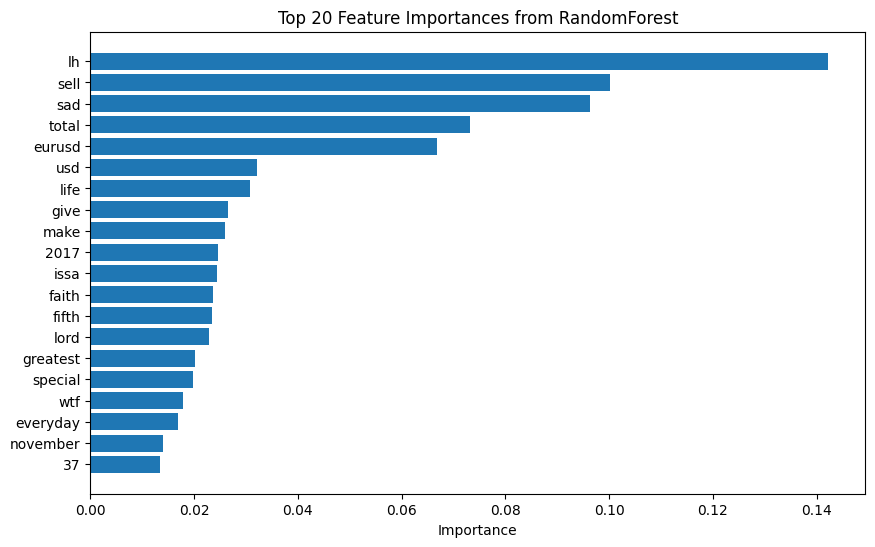

In [20]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 使用隨機森林並獲取特徵重要性

forest_model = RandomForestClassifier(n_estimators=10, max_depth=5, max_samples=0.5, random_state=42)
forest_model.fit(X_train, y_train)

importances = forest_model.feature_importances_
indices = np.argsort(importances)[-20:]  # 獲取最重要的20個特徵

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances from RandomForest")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [vectorizer.get_feature_names_out()[i] for i in indices])
plt.xlabel("Importance")
plt.show()
